# LIB's

In [1]:
import pandas as pd 

import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import numpy as np

import os 

import warnings
warnings.filterwarnings('ignore')

## HELPER FUNCTIONS


In [2]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]




## DATASET's

### DADOS CORONAVIRUS

Os dados referente aos novos casos, casos acumulados, óbitos, etc., foram extraídos da plataforma do Ministério da Saúde, veículo oficial de comunicação sobre a situação epidemiológica da COVID-19 no Brasil.

A extração foi feita em 19/01/21.

Dataset disponível em: https://covid.saude.gov.br/

In [3]:
covid = pd.read_csv(r'/Users/daianeklein/Documents/Desafio-COVID/Dados/HIST_PAINEL_COVIDBR_19jan2021.csv',
                   encoding='latin-1', sep=';')

In [4]:
# Separando os dados por UF

# Criando uma lista com as UF
uf = ['AC','AL','AP','AM','BA','CE','DF','ES','GO','MA','MT','MS','MG','PA',
'PB','PR','PE','PI','RJ','RN','RS','RO','RR','SC','SP','SE','TO']

# Selecionando as colunas alvo
colunas = ['regiao', 'estado', 'data','casosAcumulado', 'casosNovos', 'obitosAcumulado', 'obitosNovos']

covid = covid[colunas]
covid = covid[covid['estado'].isin(uf)]

covid.sample(10)

,regiao,estado,data,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos
473744,Nordeste,PE,2020-08-29,376,3,20,0
1120145,Sudeste,SP,2020-07-23,116,1,3,0
740329,Sudeste,MG,2020-04-28,0,0,0,0
873297,Sudeste,MG,2020-11-26,610,8,8,0
825153,Sudeste,MG,2020-11-21,217,0,8,0
1040837,Sudeste,SP,2020-05-11,235,3,23,0
452661,Nordeste,PE,2020-03-29,0,0,0,0
45881,Norte,AM,2020-09-04,2006,8,25,0
126667,Norte,TO,2020-10-30,358,0,5,0
964001,Sudeste,RJ,2020-05-18,10,3,0,0


### PROJEÇÃO DA POPULAÇÃO DO BRASIL POR SEXO E IDADE SIMPLES: 2000-2060

A projeção da população do Brasil é um estudo feito pelo IBGE de fundamental importância para cálculo de indicadores sociodemográficos, elaboração de políticas públicas, bem como estratégias de planejamento do setor privado.

As Projeções da População do Brasil e das Unidades da Federação são elaboradas com base nas informações sobre as componentes da dinâmica demográfica oriundas dos censos demográficos, das pesquisas domiciliares por amostragem e dos registros administrativos de nascimentos e óbitos investigados pelo IBGE. (Fonte IBGE)

O arquivo utilizado neste notebook está disponível em: http://tabnet.datasus.gov.br/cgi/deftohtm.exe?ibge/cnv/projpopbr.def

In [5]:
# importação do dataset de populacao estimada
populacao = pd.read_csv(r'/Users/daianeklein/Documents/Desafio-COVID/Dados/POPULACAO.csv',
                       encoding='latin-1', sep = ';', skiprows=3, skipfooter=4, engine='python') 

#index que serão excluídos
excluir = ['Região Norte','Região Sudeste','Região Sul','Região Centro-Oeste','Total','Região Nordeste', ' Fonte:']

# Definindo os indices
populacao.set_index('Região/Unidade da Federação', inplace=True)

# Excluindo as linhas
populacao.drop(excluir, inplace = True)

### CNES - RECURSOS FÍSICOS - HOSPITALAR - LEITOS DE INTERNAÇÃO - BRASIL

O CNES é a sigla para Cadastro Nacional de Estabelecimentos de Saúde, instituído pelo Ministério da Saúde e responsável pelo cadastro de dados de estabelecimentos que prestem assistência à saúde, seja público ou privado.

O objetivo do CNES é manter o cadastro de todos os estabelecimentos de saúde, hospitalares e ambulatoriais (consultório médico ou
odontológico isolado, consultórios de psicologia, fisioterapia, policlínicas, clinicas especializadas,
laboratórios, serviços de diagnose e terapia ou, ainda, unidade de Vigilância Sanitária ou
epidemiológica), mantendo-os atualizados para servir de suporte à estratégias e planos relacionados à saúde.

**Neste estudo, foram considerados os leitos de internação públicos e privados**

http://tabnet.datasus.gov.br/cgi/tabcgi.exe?cnes/cnv/leiintbr.def

In [6]:
leitos = pd.read_csv(r'/Users/daianeklein/Documents/Desafio-COVID/Dados/leitos.csv',
                       encoding='latin-1', sep = ';', skiprows=3, skipfooter=12, engine='python')

#index que serão excluídos
excluir = ['Região Norte','Região Sudeste','Região Sul','Região Centro-Oeste','Região Nordeste' ]

# Definindo os índices
leitos.set_index('Região/Unidade da Federação', inplace = True)

#Excluindo as linhas
leitos.drop(excluir, inplace = True)


### PROCEDIMENTOS HOSPITALARES DO SUS - POR LOCAL DE INTERNAÇÃO - BRASIL

Os dados referente aos procedimentos hospitalares são disponibilizados pelo Ministério da Saúde através da plataforma DATASUS. 

Para esta análise, foram considerados os procedimentos por local de internação e por data de processamento.
Também foram utilizados somente os atendimentos de emergência (uma vez que o foco é COVID, foram expurgados atendimentos relacionados à acidente de trabalho, trânsito, produtos químicos, etc).

http://tabnet.datasus.gov.br/cgi/deftohtm.exe?sih/cnv/qiuf.def

In [7]:
internacoes = pd.read_csv(r'/Users/daianeklein/Documents/Desafio-COVID/Dados/INTERNACOES.csv',
                       encoding='latin-1', sep = ';', skiprows=4, skipfooter=12, engine='python')

#index que serão excluídos
excluir = ['Região Norte','Região Sudeste','Região Sul','Região Centro-Oeste','Região Nordeste', ]

# Definindo os índices
internacoes.set_index('Região/Unidade da Federação', inplace = True)

#Excluindo as linhas
internacoes.drop(excluir, inplace = True)

internacoes

,2009/Jan,2009/Fev,2009/Mar,2009/Abr,2009/Mai,2009/Jun,2009/Jul,2009/Ago,2009/Set,2009/Out,...,2020/Mar,2020/Abr,2020/Mai,2020/Jun,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,Total
Região/Unidade da Federação,,,,,,,,,,,,,,,,,,,,,
.. Rondônia,5891,6608,6950,6857,7343,7032,6950,6792,6739,7134,...,8120,6498,6671,5883,7266,7228,7227,6089,5942,1082097
.. Acre,2493,2258,2264,2482,2443,2252,2169,2194,-,2373,...,2220,1831,1667,1830,1975,2192,2007,2651,2012,318843
.. Amazonas,8076,7550,10923,9855,9699,9123,9518,9736,10267,9920,...,13742,11514,12722,13301,12970,11930,13380,12285,11474,1609758
.. Roraima,1909,1625,1809,1962,2500,2072,2137,2482,2612,1814,...,3119,2848,2685,2630,2565,2889,2708,3254,2873,384759
.. Pará,37798,37466,40237,39580,39517,38518,42550,41660,41923,41556,...,35157,28291,27728,30235,30581,34738,30550,29206,27309,5276252
.. Amapá,2401,2630,2531,2771,2338,2258,2305,2229,2305,2345,...,1865,1602,1751,2053,2681,2606,2398,1778,1903,329532
.. Tocantins,7005,7570,7485,7421,7666,7718,7335,7394,7454,7454,...,6255,5897,5995,5765,6430,6056,5841,5863,5628,971293
.. Maranhão,19031,20516,21625,22096,22010,22252,22866,23362,24323,24416,...,29746,24830,25523,25054,26568,26018,25316,24775,22285,3956202
.. Piauí,15556,15397,16410,17209,17934,18614,17988,17159,17128,16748,...,13993,11632,12193,13099,13903,14437,12881,13449,8053,2252776


### PORTAL DA TRANSPARÊNCIA - Recursos Transferidos

Com o objetivo de identificar os recursos transferidos para os estados, foram utilizados os dados disponíveis no portal da transparência. 

Os dados foram extraídos do site http://www.portaltransparencia.gov.br/funcoes/10-saude?ano=2020. Não havia abertura por mês, portanto, foram utilizados os valores anuais e quando necessário, divididos por 12.

***

Não foi possível utilizar os dados disponibilizados no link: http://www.portaltransparencia.gov.br/download-de-dados/transferencias devido inconsistência nas informações (provavelmente data de processamento incorreta)

In [8]:
despesas = pd.read_csv('despesas.csv', sep=';', encoding='UTF-8')
despesas 

,LOCALIDADE,2016,2017,2018,2019,2020
0,Acre,295084471,"296810594,4","356892876,3","370052003,6",432255159
1,Alagoas,1085344451,1115745214,1357440089,1469948488,1482194788
2,Amapá,"213565337,5","207071360,6","250371774,5","244969340,1","385382870,2"
3,Amazonas,"914760077,6","903687628,1","993738417,4",1085240205,1275896645
4,Bahia,4255454408,4320569086,4901940202,5273034706,5624715575
5,Ceará,2777013793,2957495853,3262145797,3567192479,3687313681
6,Distrito Federal,7739009392,7986980907,7233719959,6749097566,6107228349
7,Espírito Santo,1055926663,1101778678,1223234672,1351502879,1373350234
8,Goiás,1800106720,1831349004,2066091021,2277628619,2455398948
9,Maranhão,1928363298,1978617665,2262914387,2426943630,2489307917


### TRANFORMAÇÃO DOS DADOS



In [9]:
# Alteração do tipo de dado
covid['data'] = covid['data'].astype('datetime64')

In [10]:
# Criação de uma coluna com dia, mes e ano
covid['dia'] = covid['data'].dt.day
covid['mes'] = covid['data'].dt.month
covid['ano'] = covid['data'].dt.year

## ANÁLISES MACROS

In [11]:
novos_casos = covid[['data', 'casosNovos']].groupby('data').sum().reset_index()

<Figure size 432x288 with 0 Axes>

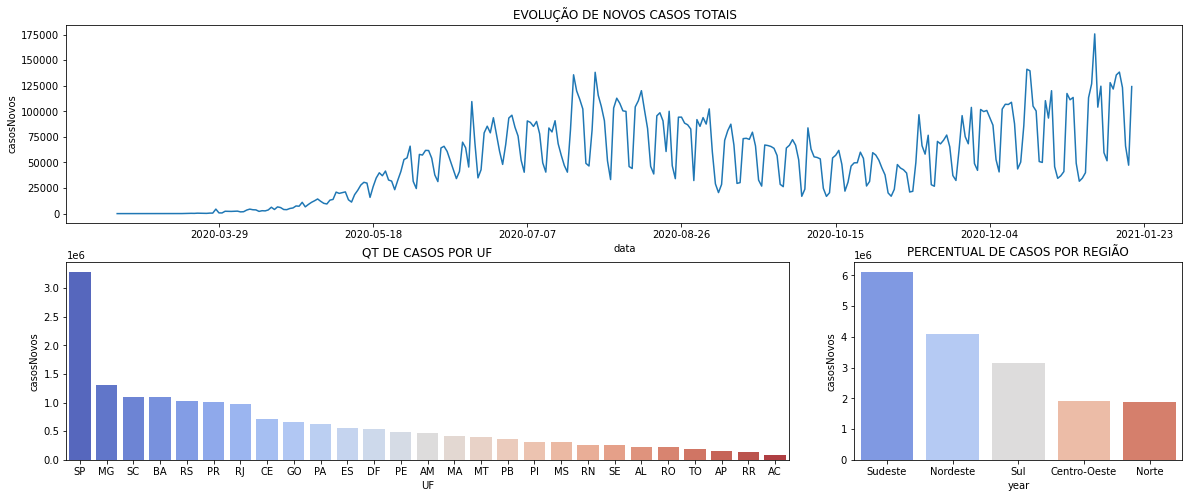

In [12]:
fig3 = plt.figure(constrained_layout=True)
fig3 = plt.figure(figsize=(20,8))

#######


gs = fig3.add_gridspec(2, 3) ## number of charts


graph1 = fig3.add_subplot(gs[0, :]) ##chart 1
graph1.set_title('EVOLUÇÃO DE NOVOS CASOS TOTAIS')
graph1 = sns.lineplot(data=novos_casos, x='data', y='casosNovos', palette='coolwarm')
graph1.xaxis.set_major_locator(ticker.AutoLocator())


#######

c = covid[['estado', 'casosNovos']].groupby('estado').sum().reset_index().sort_values(by='casosNovos',
                                                                                     ascending=False)

graph2 = fig3.add_subplot(gs[1, :-1])
graph2.set_title('QT DE CASOS POR UF')
graph2 = sns.barplot(data = c, x = 'estado', y='casosNovos', palette='coolwarm')
graph2 = plt.xlabel('UF')


#######
b = data = covid[['regiao', 'casosNovos']].groupby('regiao').sum().reset_index().sort_values(by='casosNovos', ascending=False)

graph3 = fig3.add_subplot(gs[1:, -1])
graph3.set_title('PERCENTUAL DE CASOS POR REGIÃO')
graph3 = sns.barplot(data = b, x='regiao', y='casosNovos',palette='coolwarm')
graph3 = plt.xlabel('year')


#######

fig3 = fig3



<Figure size 432x288 with 0 Axes>

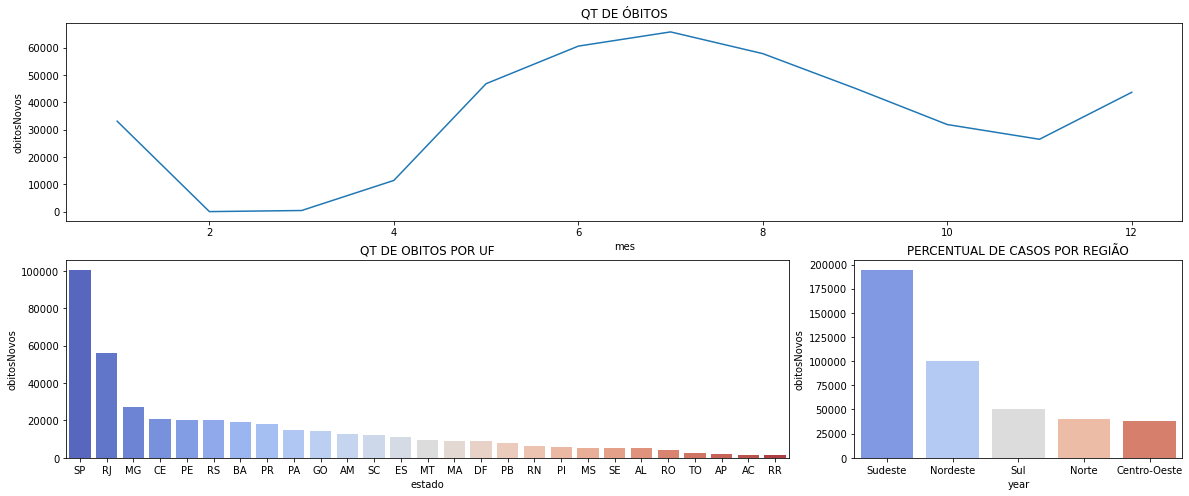

In [13]:
fig3 = plt.figure(constrained_layout=True)
fig3 = plt.figure(figsize=(20,8))

#######


gs = fig3.add_gridspec(2, 3) ## number of charts

obitos = covid[['mes', 'obitosNovos']].groupby('mes').sum()
graph1 = fig3.add_subplot(gs[0, :]) ##chart 1
graph1.set_title('QT DE ÓBITOS')
graph1 = sns.lineplot(data=obitos, x='mes', y='obitosNovos', palette='coolwarm', ci=False)
graph1.xaxis.set_major_locator(ticker.AutoLocator())


#######

obitos_uf = covid[['estado', 'obitosNovos']].groupby('estado').sum().reset_index()
order = obitos_uf.sort_values(by='obitosNovos', ascending=False)['estado']

graph2 = fig3.add_subplot(gs[1, :-1])
graph2.set_title('QT DE OBITOS POR UF')
graph2 = sns.barplot(data = obitos_uf, x ='estado',y='obitosNovos' , palette='coolwarm',
                    order = order)



#######

a = covid[['regiao', 'obitosNovos']].groupby('regiao').sum().reset_index().sort_values(by='obitosNovos', 
                                                                                       ascending=False)

graph3 = fig3.add_subplot(gs[1:, -1])
graph3.set_title('PERCENTUAL DE CASOS POR REGIÃO')
graph3 = sns.barplot(data = a, x= 'regiao', y='obitosNovos',
                     palette='coolwarm')
graph3 = plt.xlabel('year')


#######

fig3 = fig3



### COVID x POPULAÇÃO

In [14]:
# ajustando o nome dos estados
populacao.reset_index(inplace = True)
populacao['Região/Unidade da Federação'].replace('.. ', '', inplace = True, regex=True)

# Dicionario com estados e UF
siglas = {
'Acre':'AC',
'Alagoas':'AL',
'Amapá':'AP',
'Amazonas':'AM',
'Bahia':'BA',
'Ceará':'CE',
'DistriFederal':'DF',
'EspíriSanto':'ES',
'Goiás':'GO',
'Maranhão':'MA',
'MaGrosso':'MT',
'MaGrosSul':'MS',
'MinGerais':'MG',
'Pará':'PA',
'Paraíba':'PB',
'Paraná':'PR',
'Pernambuco':'PE',
'Piauí':'PI',
'RJaneiro':'RJ',
'RGranNorte':'RN',
'RGranSul':'RS',
'Rondônia':'RO',
'Roraima':'RR',
'SanCatarina':'SC',
'SPaulo':'SP',
'Sergipe':'SE',
'Tocantins':'TO'
}

# Inserindo a coluna com uf
populacao['uf'] = populacao['Região/Unidade da Federação'].map(siglas)

In [15]:
populacao_e_contagio = populacao[['uf', '2019']]

#qt de casos por UF
covid_por_uf = covid[['estado', 'casosNovos']].groupby('estado').sum().reset_index()
covid_por_uf.rename(columns={'estado' : 'uf'}, inplace=True) # renomeando as colunas

# qt de obitos por UF
obitos_por_uf = covid[['estado', 'obitosNovos']].groupby('estado').sum().reset_index()
obitos_por_uf.rename(columns={'estado' : 'uf'}, inplace=True)

populacao_e_contagio = populacao_e_contagio.merge(covid_por_uf, on='uf', how = 'inner') #inserindo casos
populacao_e_contagio = populacao_e_contagio.merge(obitos_por_uf, on='uf', how = 'inner') #inserindo obitos
populacao_e_contagio.rename(columns={'2019' : 'Populacao_2019'}, inplace=True) #renomeando a coluna 2019

In [16]:
# Calculando a qt de contagio para cada 1k de habitantes
populacao_e_contagio['contagio_1k_habitante'] = (populacao_e_contagio['casosNovos'] /  populacao_e_contagio['Populacao_2019']) * 1000

# Calculando a qt de obitos para cada 1k de habitantes
populacao_e_contagio['obitos_1k_habitante'] = (populacao_e_contagio['obitosNovos'] /  populacao_e_contagio['Populacao_2019']) * 1000

# Calculando a qt de obitos pela qt. de contagios
populacao_e_contagio['obitos_por_contagios_1k_habitantes'] = (populacao_e_contagio['obitosNovos'] / populacao_e_contagio['casosNovos'] ) * 1000

populacao_e_contagio

,uf,Populacao_2019,casosNovos,obitosNovos,contagio_1k_habitante,obitos_1k_habitante,obitos_por_contagios_1k_habitantes
0,RO,1841142.0,222744,4088,120.981434,2.220361,18.352907
1,AC,854691.0,90416,1678,105.787940,1.963283,18.558662
2,AM,4182899.0,467942,12900,111.870260,3.083986,27.567519
3,RR,538963.0,142464,1632,264.329833,3.028037,11.455526
4,PA,8544639.0,622126,14854,72.808927,1.738400,23.876192
5,AP,828028.0,148090,2020,178.846609,2.439531,13.640354
6,TO,1583391.0,194392,2646,122.769423,1.671097,13.611671
7,MA,7083578.0,407928,9236,57.587846,1.303861,22.641250
8,PI,3229651.0,304422,5936,94.258482,1.837969,19.499248
9,CE,9128090.0,712234,20480,78.026619,2.243624,28.754595


### LEITOS x POPULAÇÃO

In [17]:
# ajustando o nome dos estados
leitos.reset_index(inplace = True)
leitos['Região/Unidade da Federação'].replace('.. ', '', inplace = True, regex=True)

# Inserindo a coluna com uf
leitos['uf'] = leitos['Região/Unidade da Federação'].map(siglas)

### DESPESAS

In [18]:
despesas 

,LOCALIDADE,2016,2017,2018,2019,2020
0,Acre,295084471,"296810594,4","356892876,3","370052003,6",432255159
1,Alagoas,1085344451,1115745214,1357440089,1469948488,1482194788
2,Amapá,"213565337,5","207071360,6","250371774,5","244969340,1","385382870,2"
3,Amazonas,"914760077,6","903687628,1","993738417,4",1085240205,1275896645
4,Bahia,4255454408,4320569086,4901940202,5273034706,5624715575
5,Ceará,2777013793,2957495853,3262145797,3567192479,3687313681
6,Distrito Federal,7739009392,7986980907,7233719959,6749097566,6107228349
7,Espírito Santo,1055926663,1101778678,1223234672,1351502879,1373350234
8,Goiás,1800106720,1831349004,2066091021,2277628619,2455398948
9,Maranhão,1928363298,1978617665,2262914387,2426943630,2489307917


In [19]:
siglas2 = {'Acre':'AC',
'Alagoas':'AL',
'Amapá':'AP',
'Amazonas':'AM',
'Bahia':'BA',
'Ceará':'CE',
'Distrito Federal':'DF',
'Espírito Santo':'ES',
'Goiás':'GO',
'Maranhão':'MA',
'Mato Grosso':'MT',
'Mato Grosso do Sul':'MS',
'Minas Gerais':'MG',
'Pará':'PA',
'Paraíba':'PB',
'Paraná':'PR',
'Pernambuco':'PE',
'Piauí':'PI',
'Rio de Janeiro':'RJ',
'Rio Grande do Norte':'RN',
'Rio Grande do Sul':'RS',
'Rondônia':'RO',
'Roraima':'RR',
'Santa Catarina':'SC',
'São Paulo':'SP',
'Sergipe':'SE',
'Tocantins':'TO'}

# Inserindo a coluna com uf
despesas['uf'] = despesas['LOCALIDADE'].map(siglas2)

despesas

,LOCALIDADE,2016,2017,2018,2019,2020,uf
0,Acre,295084471,"296810594,4","356892876,3","370052003,6",432255159,AC
1,Alagoas,1085344451,1115745214,1357440089,1469948488,1482194788,AL
2,Amapá,"213565337,5","207071360,6","250371774,5","244969340,1","385382870,2",AP
3,Amazonas,"914760077,6","903687628,1","993738417,4",1085240205,1275896645,AM
4,Bahia,4255454408,4320569086,4901940202,5273034706,5624715575,BA
5,Ceará,2777013793,2957495853,3262145797,3567192479,3687313681,CE
6,Distrito Federal,7739009392,7986980907,7233719959,6749097566,6107228349,DF
7,Espírito Santo,1055926663,1101778678,1223234672,1351502879,1373350234,ES
8,Goiás,1800106720,1831349004,2066091021,2277628619,2455398948,GO
9,Maranhão,1928363298,1978617665,2262914387,2426943630,2489307917,MA


### INTERNAÇÕES 

In [20]:
# ajustando o nome dos estados
internacoes.reset_index(inplace = True)
internacoes['Região/Unidade da Federação'].replace('.. ', '', inplace = True, regex=True)

# Inserindo a coluna com uf
internacoes['uf'] = internacoes['Região/Unidade da Federação'].map(siglas)

In [21]:
internacoes

,Região/Unidade da Federação,2009/Jan,2009/Fev,2009/Mar,2009/Abr,2009/Mai,2009/Jun,2009/Jul,2009/Ago,2009/Set,...,2020/Abr,2020/Mai,2020/Jun,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,Total,uf
0,Rondônia,5891,6608,6950,6857,7343,7032,6950,6792,6739,...,6498,6671,5883,7266,7228,7227,6089,5942,1082097,RO
1,Acre,2493,2258,2264,2482,2443,2252,2169,2194,-,...,1831,1667,1830,1975,2192,2007,2651,2012,318843,AC
2,Amazonas,8076,7550,10923,9855,9699,9123,9518,9736,10267,...,11514,12722,13301,12970,11930,13380,12285,11474,1609758,AM
3,Roraima,1909,1625,1809,1962,2500,2072,2137,2482,2612,...,2848,2685,2630,2565,2889,2708,3254,2873,384759,RR
4,Pará,37798,37466,40237,39580,39517,38518,42550,41660,41923,...,28291,27728,30235,30581,34738,30550,29206,27309,5276252,PA
5,Amapá,2401,2630,2531,2771,2338,2258,2305,2229,2305,...,1602,1751,2053,2681,2606,2398,1778,1903,329532,AP
6,Tocantins,7005,7570,7485,7421,7666,7718,7335,7394,7454,...,5897,5995,5765,6430,6056,5841,5863,5628,971293,TO
7,Maranhão,19031,20516,21625,22096,22010,22252,22866,23362,24323,...,24830,25523,25054,26568,26018,25316,24775,22285,3956202,MA
8,Piauí,15556,15397,16410,17209,17934,18614,17988,17159,17128,...,11632,12193,13099,13903,14437,12881,13449,8053,2252776,PI
9,Ceará,29988,30344,37044,35114,35483,34159,34035,34148,33212,...,30479,30562,32837,33114,30923,30158,31381,29086,4628404,CE


In [22]:
table_mes = pd.DataFrame(covid[['mes', 'casosNovos']].groupby('mes').sum())
table_mes.style.apply(highlight_max)

,casosNovos
mes,
1,1795782
2,2
3,11459
4,159426
5,857513
6,1775682
7,2520888
8,2491574
9,1805326
